<a href="https://colab.research.google.com/github/Joovvhan/Master-Thesis/blob/master/log/CWRU_Normal_vs_Fault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime

from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras import backend as K
from keras.models import load_model

dataPath = 'D:/Case Western Reserve University Bearing Data'
savePath = dataPath

folders = ['Normal Baseline Data', '12k Drive End Bearing Fault Data',
           'Fan-End Bearing Fault Data', '48k Drive End Bearing Fault Data']

sensPos = 'DE'

Using TensorFlow backend.


In [0]:
pretrainedModel = 'VGG19'
pretrainedModel = 'Xception'
pretrainedModel = 'ResNet50'

lastActivation = 'softmax'
sizeBatch = 4
numEpochs = 8
verb = 1

fs = 12000
nsc = 448
nov = np.floor(nsc/2)
nff = nsc
imgSize = 224

In [0]:
npyFileList = glob.glob(savePath + '/' + '*.npy')

In [0]:
normalFile = [file for file in npyFileList if 'Normal' in file]

b028File = [file for file in npyFileList if '28' in file]

trainingRatio = 0.8

In [0]:
for i in range(len(normalFile)):
    imgs = np.load(normalFile[i])
    if i == 0:
        imgsNormal = imgs
    else:
        imgsNormal = np.vstack([imgsNormal, imgs])       
        
for i in range(len(b028File)):
    imgs = np.load(b028File[i])
    if i == 0:
        imgsFault = imgs
    else:
        imgsFault = np.vstack([imgsFault, imgs])

In [8]:
# Change name from imgsF1 or imgsF5 to imgsNormal and imgsFault

dataNumNormal = len(imgsNormal)
dataNumFault = len(imgsFault)
dataNumNormalTrain = int(dataNumNormal * trainingRatio)
dataNumFaultTrain = int(dataNumFault * trainingRatio)
dataNumNormalTest = dataNumNormal - dataNumNormalTrain
dataNumFaultTest = dataNumFault - dataNumFaultTrain

print('Normal Train:Test = {:d}:{:d}'.format(dataNumNormalTrain, dataNumNormalTest))
print('Fault  Train:Test = {:d}:{:d}\n'.format(dataNumFaultTrain, dataNumFaultTest))

trainIdxNormal = np.random.choice(dataNumNormal - 1, dataNumNormalTrain, replace=False)
testIdxNormal = list(set(range(0, dataNumNormal)) - set(trainIdxNormal))

trainImgsNormal = imgsNormal[trainIdxNormal, :, :]
testImgsNormal = imgsNormal[testIdxNormal, :, :]

print('Normal Training Image Shape {}'.format(trainImgsNormal.shape))
print('Normal Test Image Shape {}\n'.format(testImgsNormal.shape))

trainIdxFault  = np.random.choice(dataNumFault - 1, dataNumFaultTrain, replace=False)
testIdxFault = list(set(range(0, dataNumFault)) - set(trainIdxFault))

trainImgsFault = imgsFault[trainIdxFault, :, :]
testImgsFault = imgsFault[testIdxFault, :, :]

print('Fault Training Image Shape {}'.format(trainImgsFault.shape))
print('Fault Test Image Shape {}\n'.format(testImgsFault.shape))

trainImgs = np.vstack([trainImgsNormal, trainImgsFault])
testImgs = np.vstack([testImgsNormal, testImgsFault])

print('Training Image Shape {}'.format(trainImgs.shape))
print('Test Image Shape {}'.format(testImgs.shape))

Normal Train:Test = 800:200
Fault  Train:Test = 800:200

Normal Training Image Shape (800, 224, 224)
Normal Test Image Shape (200, 224, 224)

Fault Training Image Shape (800, 224, 224)
Fault Test Image Shape (200, 224, 224)

Training Image Shape (1600, 224, 224)
Test Image Shape (400, 224, 224)


In [9]:
trainMean = np.mean(trainImgs)
trainStd = np.std(trainImgs)

print('Mean of Training Image: {}'.format(trainMean))
print('Standard Deviation of Training Image: {}'.format(trainStd))

Mean of Training Image: -66.2454329787468
Standard Deviation of Training Image: 21.7406713031756


In [0]:
# Should Change Norm to Normalized

trainImgsNorm = (trainImgs - trainMean) / trainStd
testImgsNorm = (testImgs - trainMean) / trainStd

trainImgsNorm = trainImgsNorm.reshape(list(trainImgsNorm.shape) + [1])
testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

In [11]:
X_train = np.stack([trainImgsNorm[:, :, :, 0], trainImgsNorm[:, :, :, 0], trainImgsNorm[:, :, :, 0]], axis = -1)
X_test = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)

print('X_train Shape: {}'.format(X_train.shape))
print('X_test  Shape: {}'.format(X_test.shape))

X_train Shape: (1600, 224, 224, 3)
X_test  Shape: (400, 224, 224, 3)


In [12]:
trainLabelNormal = np.stack((np.ones(dataNumNormalTrain), np.zeros(dataNumNormalTrain)), axis = -1)
testLabelNormal = np.stack((np.ones(dataNumNormalTest), np.zeros(dataNumNormalTest)), axis = -1)

trainLabelFault = np.stack((np.zeros(dataNumFaultTrain), np.ones(dataNumFaultTrain)), axis = -1)
testLabelFault = np.stack((np.zeros(dataNumFaultTest), np.ones(dataNumFaultTest)), axis = -1)

Y_train = np.vstack((trainLabelNormal, trainLabelFault))
Y_test = np.vstack((testLabelNormal, testLabelFault))

print('Y_train Normal:Fault = {:d}:{:d}'.format(len(trainLabelNormal), len(trainLabelFault)))
print('Y_test  Normal:Fault = {:d}:{:d}'.format(len(testLabelNormal), len(testLabelFault)))

Y_train Normal:Fault = 800:800
Y_test  Normal:Fault = 200:200


In [13]:
from keras.applications import VGG19
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3

# Refresh all background variables
K.clear_session()

input_tensor = Input(shape=(imgSize, imgSize, 3))

# Building sequential model with name 'model'
model = Sequential()

# Model selection

if (pretrainedModel == 'VGG16'):
    
    modelWoTop = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=lastActivation))
    
elif (pretrainedModel == 'VGG19'):
    
    modelWoTop = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=lastActivation))
              
elif pretrainedModel == 'ResNet50':
    
    modelWoTop = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(2, activation=lastActivation))
              
elif (pretrainedModel == 'InceptionV3'):
    modelWoTop = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
    
elif (pretrainedModel == 'Xception'):
    modelWoTop = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
                      
elif (pretrainedModel == 'DenseNet169'):

    modelWoTop = DenseNet169(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
              
elif (pretrainedModel == 'DenseNet201'):
    modelWoTop = DenseNet201(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
              
else:
    print('Invalid Pretrained Model Selection')
    
              

# Model compiling

print('Compiling Pretrained {} Model'.format(model.layers[0].name))
              
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

c:\users\주환\appdata\local\conda\conda\envs\paper\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Compiling Pretrained resnet50 Model


In [20]:
print('Training Pretrained {} Model'.format(model.layers[0].name))
print('Batch Size: {}\t Epochs: {}\t\n'.format(sizeBatch, numEpochs))

numEpochs = 2

model.fit(X_train, Y_train,
          batch_size=sizeBatch, epochs=numEpochs, verbose=1,
          validation_data=(X_test, Y_test))

Y_pred = model.predict(X_test)

Training Pretrained resnet50 Model
Batch Size: 4	 Epochs: 8	

Train on 1600 samples, validate on 400 samples
Epoch 1/2
1600/1600 [==============================] - 66s 41ms/step - loss: 1.9984e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 2/2
1600/1600 [==============================] - 66s 41ms/step - loss: 1.6486e-07 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000


In [0]:
testFile = [file for file in npyFileList if ('Normal' not in file) and ('28' not in file)]

trainingRatio = 0.8

for i in range(len(testFile)):
    imgs = np.load(testFile[i])
    if i == 0:
        imgsTest = imgs
    else:
        imgsTest = np.vstack([imgsTest, imgs])

In [24]:
# Should Change Norm to Normalized

imgsTestNorm = (imgsTest - trainMean) / trainStd

imgsTestNorm = imgsTestNorm.reshape(list(imgsTestNorm.shape) + [1])

X_test_test = np.stack([imgsTestNorm[:, :, :, 0], imgsTestNorm[:, :, :, 0], imgsTestNorm[:, :, :, 0]], axis = -1)

print('X_test_test Shape: {}'.format(X_test_test.shape))

X_test_test Shape: (3000, 224, 224, 3)


In [0]:
Y_pred_test = model.predict(X_test_test)

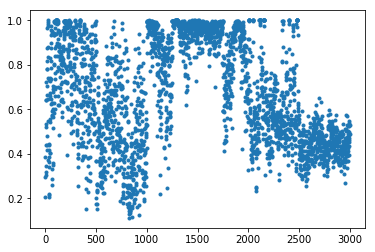

In [27]:
plt.plot(Y_pred_test[:, 1], '.')

In [0]:
Y_pred_test_binary = np.argmax(Y_pred_test, axis = -1)

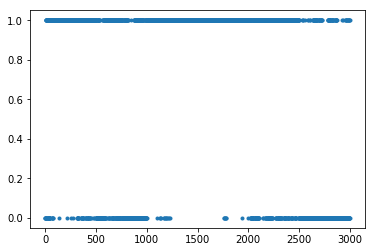

In [37]:
plt.plot(Y_pred_test_binary, '.')

In [0]:
from keras.models import Model

layer_name = 'flatten_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_test)

[0.96206695 0.00736193]
[8432.707   737.6669]


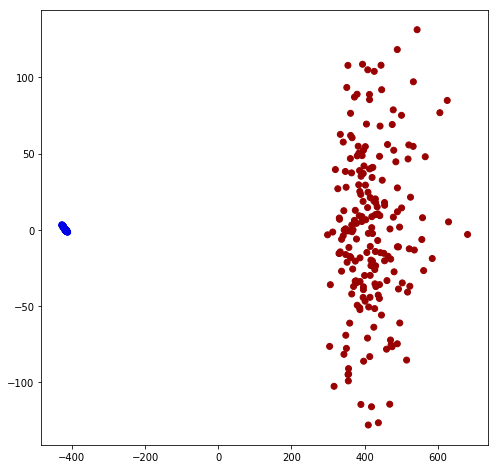

In [40]:
import numpy as np
from sklearn.decomposition import PCA

layer_name = 'flatten_1'
intermediate_layer_model = Model(inputs=model.input,
outputs=model.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict(X_test)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(intermediate_output)

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

red = np.array([0.6, 0, 0, 1])
blue = np.array([0, 0, 0.9, 1])

Y_label = np.argmax(Y_test, axis = -1)

clusterColor = [red * label + blue * (1 - label) for label in Y_label]

plt.figure(figsize=(8, 8))
plt.scatter(x = pca_result[:, 0], y=pca_result[:, 1], color=clusterColor)
plt.show()

[0.96206695 0.00736193]
[8432.707   737.6669]


ValueError: ignored

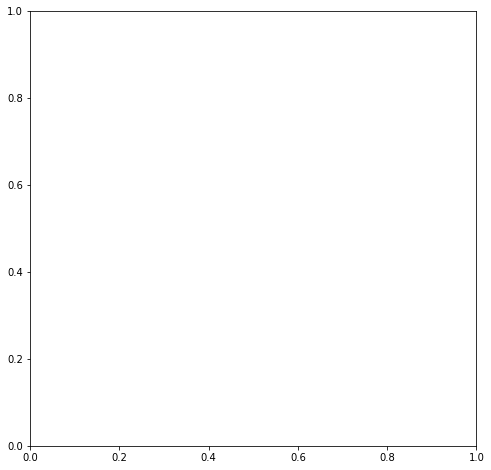

In [70]:
intermediate_output_test = intermediate_layer_model.predict(X_test_test)

pca_result_test = pca.transform(intermediate_output_test)

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

red = np.array([0.6, 0, 0, 1])
blue = np.array([0, 0, 0.9, 1])

yellow = np.array([1, 0.85, 0, 0.1])
chartreuse = np.array([0.5, 1, 0, 0.1])
green = np.array([0.2, 0.55, 0.2, 0.1])

# clusterColorTest = [red * label + blue * (1 - label) for label in Y_label]

clusterColorTest = np.vstack([np.repeat([green], 1000, axis = 0), np.repeat([chartreuse], 1000, axis = 0), np.repeat([yellow], 1000, axis = 0)])

plt.figure(figsize=(8, 8))
plt.scatter(x = pca_result_test[:, 0], y=pca_result_test[:, 1], color=clusterColorTest)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(x = [pca_result[:, 0], pca_result_test[:, 0]], y = [pca_result[:, 1], pca_result_test[:, 1]], color=[clusterColor, clusterColorTest])
plt.show()

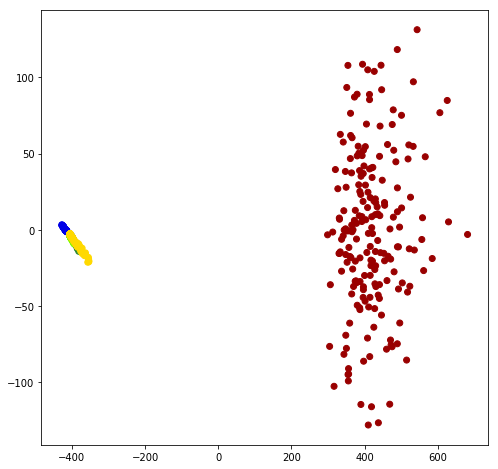

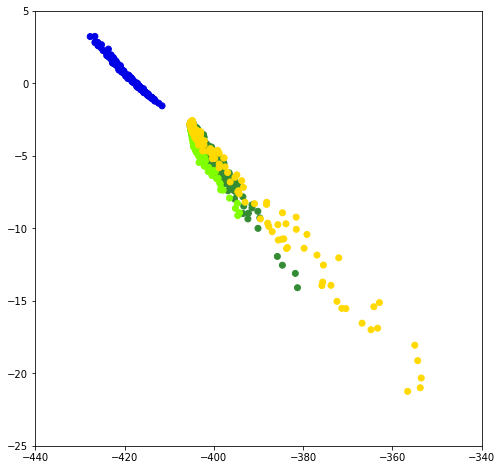

In [110]:
yellow = np.array([1, 0.85, 0, 1])
chartreuse = np.array([0.5, 1, 0, 1])
green = np.array([0.2, 0.55, 0.2, 1])

# clusterColorTest = [red * label + blue * (1 - label) for label in Y_label]

clusterColorTest = np.vstack([np.repeat([green], 1000, axis = 0), np.repeat([chartreuse], 1000, axis = 0), np.repeat([yellow], 1000, axis = 0)])

plt.figure(figsize=(8, 8))
plt.scatter(x = np.concatenate([pca_result[:, 0], pca_result_test[:, 0]]), y = np.concatenate([pca_result[:, 1], pca_result_test[:, 1]]), color=np.vstack([clusterColor, clusterColorTest]))
plt.show()

plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.scatter(x = np.concatenate([pca_result[:, 0], pca_result_test[:, 0]]), y = np.concatenate([pca_result[:, 1], pca_result_test[:, 1]]), color=np.vstack([clusterColor, clusterColorTest]))
plt.xlim(-440, -340)
plt.ylim(-25, 5)
plt.show()

In [0]:
plt.figure(figsize=(8, 8))
plt.scatter(x = np.concatenate([pca_result[:, 0], pca_result_test[:, 0]]), y = np.concatenate([pca_result[:, 1], pca_result_test[:, 1]]), color=np.vstack([clusterColor, clusterColorTest]))
plt.show()

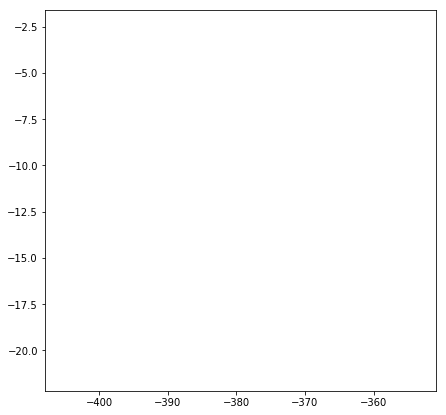

In [68]:
from matplotlib import animation, rc
from IPython.display import display, HTML

rc('animation', html='jshtml')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
# ax = fig.add_axes([0, 0, 1, 1])
ax = fig.add_subplot(111)
# ax.set_xlim(-50, 150)
# ax.set_ylim(-20, 20)
# Construct the scatter which we will update during animation
# as the raindrops develop.
x, y = [], []

yellow = np.array([1, 0.85, 0, 0.1])
chartreuse = np.array([0.5, 1, 0, 0.1])
green = np.array([0.2, 0.55, 0.2, 0.1])

clusterColorTest = np.vstack([np.repeat([green], 1000, axis = 0), np.repeat([chartreuse], 1000, axis = 0), np.repeat([yellow], 1000, axis = 0)])

scat = ax.scatter(pca_result_test[:, 0], pca_result_test[:, 1], color = np.r_[np.asarray(clusterColorTest)])


def update(frame_number):

    x = pca_result_test[:frame_number,0]
    y = pca_result_test[:frame_number,1]
  
    scat.set_offsets(np.c_[x, y])

    return scat,

# Construct the animation, using the update function as the animation
# director.
animation = FuncAnimation(fig, update, frames=np.asarray(range(0, 3000, 50)), interval=100)

In [69]:
animation